In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

import warnings
warnings.filterwarnings('ignore')

/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
df = pd.read_csv('course_730.csv', engine='python')

df_org = df

df = df.drop([list(df)[0], list(df)[-3], 'final_score', 'group'], axis=1)
#df = df.drop(['hw1_score', 'hw2_score', 'hw3_score', 'student_id'], axis=1)
df = df.drop(['student_id', 'hw2_score', 'hw3_score'], axis=1)

df = df.drop(['HW1_C', 'HW1_R', 'HW1_W', 'HW1_E'], axis=1)
df = df.drop(['HW2_C', 'HW2_R', 'HW2_W', 'HW2_E'], axis=1)
df = df.drop(['HW3_C', 'HW3_R', 'HW3_W', 'HW3_E'], axis=1)

df = df.rename(index=str, columns={list(df)[-1]: "label_2",
                              list(df)[-2]: "label_1"})
df = df[df.HW1.notna()]
df = df[df.HW2.notna()]
df = df[df.HW3.notna()]
df = df[df.HW3.notna()]
df = df[df.HW2 != 'error']
df = df[df.label_2 != '?�修']
df = df[df.label_1.notna()]


In [3]:
feature_list = list(df)
hw1_df = df[feature_list[3:14]]
hw1_df.head()

,hw1_score,w1_onlineDays,w1_onlineCount,w1_onlineTime,w1_passCount,w1_failCount,w1_SyntaxError,w1_NameError,w1_IndentationError,w1_ValueError,w1_TypeError
0,25.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,25.0,2.0,1.0,6002.317,62.0,38.0,11.0,8.0,7.0,0.0,12.0
8,25.0,1.0,1.0,3470.740,14.0,18.0,14.0,0.0,2.0,0.0,0.0
9,25.0,1.0,1.0,4327.470,58.0,27.0,8.0,14.0,3.0,0.0,2.0
12,25.0,1.0,1.0,3871.781,36.0,25.0,16.0,4.0,5.0,0.0,0.0


In [4]:
hw1_df_km = hw1_df

hw1_df_km['class'] = hw1_df_km['hw1_score'] < 24
hw1_df_km['duration'] = hw1_df_km['w1_onlineTime'] / 60
hw1_df_km['duration'] = hw1_df_km['duration'].astype(int)

hw1_df_km = hw1_df_km.drop(['hw1_score', 'w1_onlineTime'], axis=1)
hw1_df_km

,w1_onlineDays,w1_onlineCount,w1_passCount,w1_failCount,w1_SyntaxError,w1_NameError,w1_IndentationError,w1_ValueError,w1_TypeError,class,duration
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0
5,2.0,1.0,62.0,38.0,11.0,8.0,7.0,0.0,12.0,False,100
8,1.0,1.0,14.0,18.0,14.0,0.0,2.0,0.0,0.0,False,57
9,1.0,1.0,58.0,27.0,8.0,14.0,3.0,0.0,2.0,False,72
12,1.0,1.0,36.0,25.0,16.0,4.0,5.0,0.0,0.0,False,64
14,1.0,1.0,28.0,15.0,3.0,7.0,5.0,0.0,0.0,False,55
15,1.0,1.0,18.0,3.0,1.0,1.0,0.0,0.0,0.0,False,97
16,1.0,1.0,29.0,9.0,5.0,0.0,4.0,0.0,0.0,False,49
17,1.0,1.0,27.0,16.0,11.0,1.0,0.0,0.0,4.0,False,63
18,1.0,1.0,31.0,12.0,11.0,1.0,0.0,0.0,0.0,False,101


# Distribution

<Figure size 1080x1080 with 0 Axes>

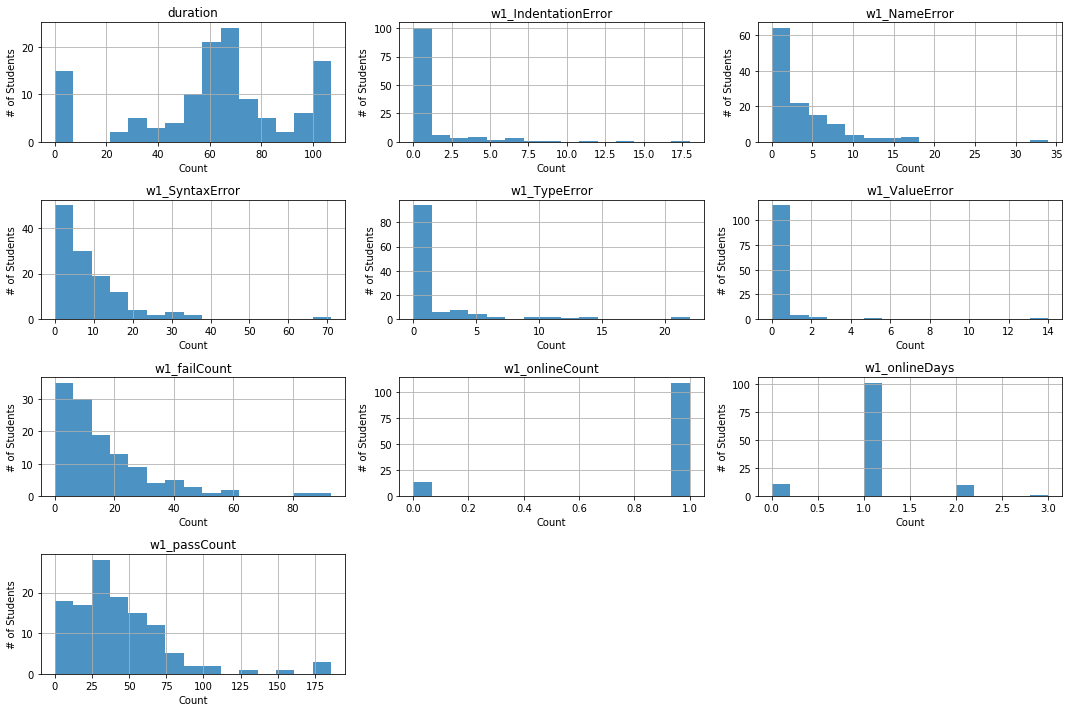

In [5]:
plt.figure(figsize=(15, 15))
ax = hw1_df_km.drop(['class'], axis=1).hist(alpha=0.8, bins=15, figsize=(15, 10))
#for x in ax:
#     x.set_title('x')

for array in ax:
    for subplot in array:
        subplot.set_ylabel('# of Students')
        subplot.set_xlabel('Count')

plt.tight_layout()
plt.savefig('svm_conf.png', dpi=400)

# KaplanMeierFitter

In [6]:
kmf = KaplanMeierFitter() 
kmf.fit(durations = hw1_df_km.duration, event_observed = hw1_df_km['class'])
#kmf.event_table

<lifelines.KaplanMeierFitter: fitted with 123 observations, 96 censored>

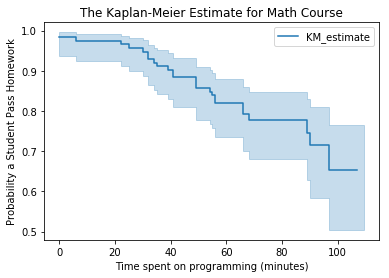

In [7]:
# plot the KM estimate
kmf.plot()
# Add title and y-axis label
plt.title("The Kaplan-Meier Estimate for Math Course")
plt.ylabel("Probability a Student Pass Homework")
plt.xlabel("Time spent on programming (minutes)")

plt.show()

In [8]:

#variable = 'w1_ValueError'
#threadhold = 1

#variable = 'w1_TypeError'
#threadhold = 3


variable = 'w1_SyntaxError'
threadhold = 10

#best fit
#variable = 'w1_passCount'
#threadhold = 25

hw1_df_km['class_passCount'] = hw1_df_km[variable] < threadhold
#hw1_df_km['class_passCount'] = hw1_df_km.w1_TypeError < 3
hw1_df_km = hw1_df_km.drop([variable], axis=1)
hw1_df_km

,w1_onlineDays,w1_onlineCount,w1_passCount,w1_failCount,w1_NameError,w1_IndentationError,w1_ValueError,w1_TypeError,class,duration,class_passCount
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,True
5,2.0,1.0,62.0,38.0,8.0,7.0,0.0,12.0,False,100,False
8,1.0,1.0,14.0,18.0,0.0,2.0,0.0,0.0,False,57,False
9,1.0,1.0,58.0,27.0,14.0,3.0,0.0,2.0,False,72,True
12,1.0,1.0,36.0,25.0,4.0,5.0,0.0,0.0,False,64,False
14,1.0,1.0,28.0,15.0,7.0,5.0,0.0,0.0,False,55,True
15,1.0,1.0,18.0,3.0,1.0,0.0,0.0,0.0,False,97,True
16,1.0,1.0,29.0,9.0,0.0,4.0,0.0,0.0,False,49,True
17,1.0,1.0,27.0,16.0,1.0,0.0,0.0,4.0,False,63,False
18,1.0,1.0,31.0,12.0,1.0,0.0,0.0,0.0,False,101,False


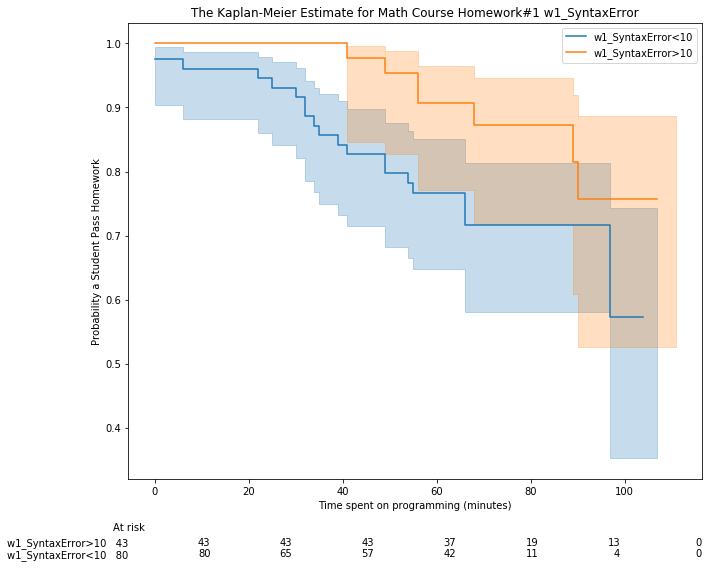

In [9]:
from lifelines import KaplanMeierFitter

ix = hw1_df_km['class_passCount'] == True

plt.figure(figsize=(10, 8))
ax = plt.subplot(111)

kmf_control = KaplanMeierFitter()
ax = kmf_control.fit(hw1_df_km.loc[ix]['duration'], 
                     hw1_df_km.loc[ix]['class'], 
                     label = variable + '<' + str(threadhold)).plot(ax=ax)

kmf_exp = KaplanMeierFitter()
ax = kmf_exp.fit(hw1_df_km.loc[~ix]['duration'], 
                 hw1_df_km.loc[~ix]['class'],
                 label = variable + '>' + str(threadhold)).plot(ax=ax)

plt.title("The Kaplan-Meier Estimate for Math Course Homework#1 " +  variable)
plt.ylabel("Probability a Student Pass Homework")
plt.xlabel("Time spent on programming (minutes)")

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_exp, kmf_control, ax=ax)

plt.tight_layout()
plt.savefig('km_hw1_passcount.png', dpi=400)

# LogRank

In [10]:
from lifelines.statistics import multivariate_logrank_test


results = multivariate_logrank_test(hw1_df_km['duration'], 
                                    hw1_df_km['class_passCount'], 
                                    hw1_df_km['class'])
results.print_summary()

<lifelines.StatisticalResult>
 null_distribution = chi squared
degrees_of_freedom = 1
               t_0 = -1

---
test_statistic    p  -log2(p)
          4.06 0.04      4.51


# Cox Proportional Hazard Model

In [11]:
from lifelines.datasets import load_regression_dataset
regression_dataset = load_regression_dataset()

regression_dataset.head()

,var1,var2,var3,T,E
0,0.595170,1.143472,1.571079,14.785652,1
1,0.209325,0.184677,0.356980,7.335846,1
2,0.693919,0.071893,0.557960,5.269797,1
3,0.443804,1.364646,0.374221,11.684092,1
4,1.613324,0.125566,1.921325,7.639492,1


<lifelines.CoxPHFitter: fitted with 123 observations, 96 censored>
      duration col = 'duration'
         event col = 'class'
number of subjects = 123
  number of events = 27
    log-likelihood = -95.96
  time fit was run = 2019-02-10 08:41:08 UTC

---
                     coef  exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
w1_onlineDays       -0.38       0.69      0.59 -0.63   0.53      0.92       -1.54        0.79
w1_passCount        -0.07       0.93      0.02 -4.51 <0.005     17.21       -0.10       -0.04
w1_failCount         0.05       1.05      0.03  2.04   0.04      4.60        0.00        0.10
w1_NameError         0.13       1.14      0.05  2.47   0.01      6.21        0.03        0.24
w1_IndentationError  0.08       1.08      0.07  1.11   0.27      1.91       -0.06        0.22
w1_ValueError        0.20       1.22      0.08  2.39   0.02      5.91        0.04        0.36
w1_TypeError        -0.07       0.94      0.07 -0.99   0.32      1.64       -0.19      

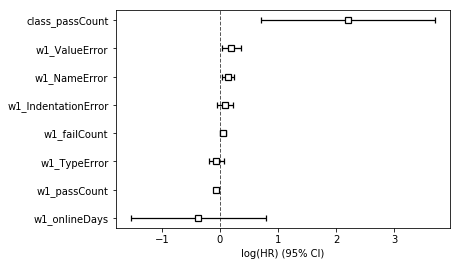

In [12]:
from lifelines import CoxPHFitter

hw1_df_km = hw1_df_km.drop(['w1_onlineCount'], axis=1)

# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(hw1_df_km, duration_col='duration', event_col='class')
cph.print_summary()

"""
<lifelines.CoxPHFitter: fitted with 200 observations, 11 censored>
      duration col = 'T'
         event col = 'E'
number of subjects = 200
  number of events = 189
    log-likelihood = -807.62
  time fit was run = 2019-01-27 23:11:22 UTC

---
      coef  exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
var1  0.22       1.25      0.07 2.99 <0.005      8.49        0.08        0.37
var2  0.05       1.05      0.08 0.61   0.54      0.89       -0.11        0.21
var3  0.22       1.24      0.08 2.88 <0.005      7.97        0.07        0.37
---
Concordance = 0.58
Likelihood ratio test = 15.54 on 3 df, -log2(p)=9.47
"""

cph.plot()